In [1]:
# Importing relevant libraries for ARIMA modeling

import pandas as pd
import numpy as np
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller
import warnings
# Suppress warnings
import warnings
warnings.filterwarnings("ignore")


In [2]:


# Load the data
file_path = '/Users/gorji1/Desktop/MSC_RESEARCH_PROJECT/Data_sets/final_time_series.csv'
data = pd.read_csv(file_path)

# Display the first few rows of the dataframe and its summary
data.info(), data.head()

data = pd.read_csv(file_path)

# Display the first few rows of the dataframe and its summary
data.info(), data.head()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 108 entries, 0 to 107
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Year           108 non-null    object 
 1   no_of_attacks  108 non-null    float64
dtypes: float64(1), object(1)
memory usage: 1.8+ KB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 108 entries, 0 to 107
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Year           108 non-null    object 
 1   no_of_attacks  108 non-null    float64
dtypes: float64(1), object(1)
memory usage: 1.8+ KB


(None,
          Year  no_of_attacks
 0  2014-01-31           36.0
 1  2014-02-28           24.0
 2  2014-03-31           34.0
 3  2014-04-30           38.0
 4  2014-05-31           16.0)

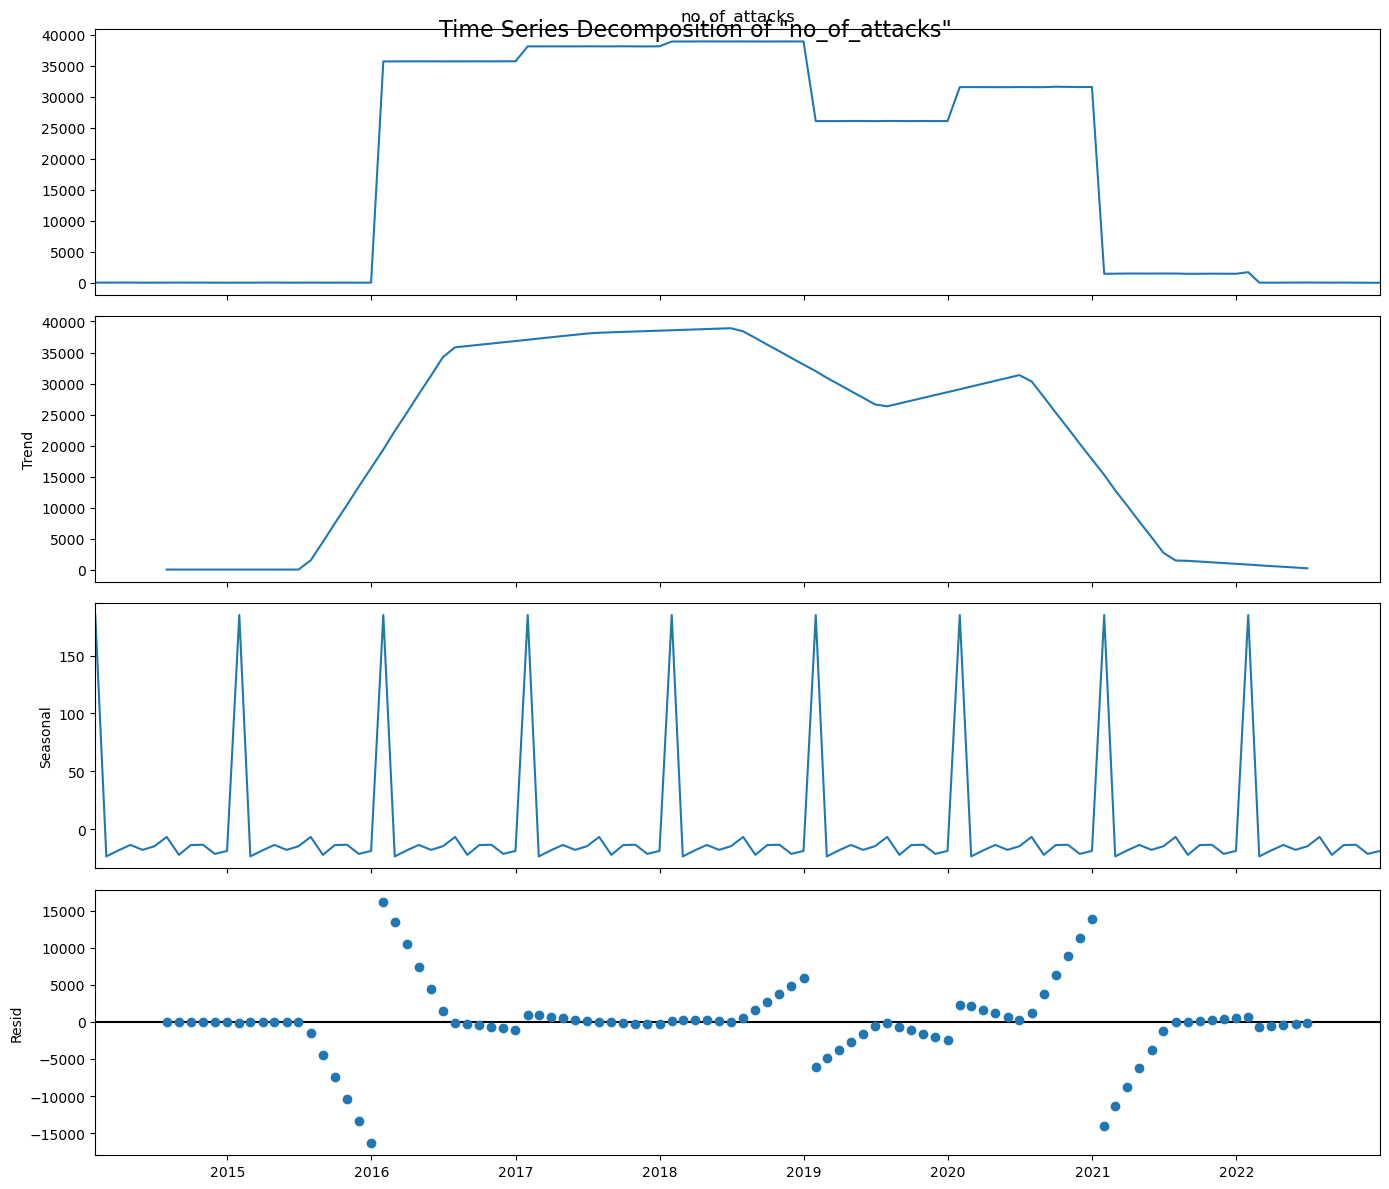

In [3]:
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose

# Convert the 'Year' column to datetime format and set it as the index
data['Year'] = pd.to_datetime(data['Year'])
data.set_index('Year', inplace=True)

# Perform seasonal decomposition
decomposition = seasonal_decompose(data['no_of_attacks'], model='additive')

# Plot the original data, the trend, the seasonality, and the residuals
plt.rcParams["figure.figsize"] = (14, 12)
fig = decomposition.plot()
plt.suptitle('Time Series Decomposition of "no_of_attacks"', fontsize=16)
plt.show()


In [4]:
from statsmodels.tsa.stattools import adfuller

# Function to test stationarity
def check_stationarity(timeseries):
    # Dickey-Fuller test
    result = adfuller(timeseries)
    return result

# Testing stationarity on the 'no_of_attacks' data
adf_result = check_stationarity(data['no_of_attacks'])

adf_result


(-1.4288467643489848,
 0.5683711765530164,
 0,
 107,
 {'1%': -3.492995948509562,
  '5%': -2.888954648057252,
  '10%': -2.58139291903223},
 1871.2937956851688)

In [5]:
import warnings
from statsmodels.tsa.arima.model import ARIMA

# Helper function to fit ARIMA model and suppress warnings during fitting
def fit_arima(data, order):
    with warnings.catch_warnings():
        warnings.filterwarnings("ignore")
        model = ARIMA(data, order=order)
        model_fit = model.fit()
    return model_fit

# Setting the range for the grid search
p_values = range(0, 5)
d_values = [1]  # Based on our earlier differencing
q_values = range(0, 5)

# Tracking the best model and AIC score
best_model = None
best_aic = float("inf")
best_order = None

# Grid searching for the best ARIMA model based on AIC
for p in p_values:
    for q in q_values:
        order = (p, d_values[0], q)
        try:
            # Fit the model with current parameters
            model_fit = fit_arima(data['no_of_attacks'], order)
            
            # Check if the current model is better than the previous best
            if model_fit.aic < best_aic:
                best_model = model_fit
                best_aic = model_fit.aic
                best_order = order
        except Exception as e:
            continue  # Skip if the model failed to fit

# Once we have the best model, we can present its properties
if best_model is not None:
    print(f"Best ARIMA{best_order} Model Summary:")
    print(best_model.summary())
else:
    print("No suitable ARIMA model was found.")


Best ARIMA(0, 1, 0) Model Summary:
                               SARIMAX Results                                
Dep. Variable:          no_of_attacks   No. Observations:                  108
Model:                 ARIMA(0, 1, 0)   Log Likelihood               -1057.094
Date:                Sun, 22 Oct 2023   AIC                           2116.189
Time:                        21:55:02   BIC                           2118.862
Sample:                    01-31-2014   HQIC                          2117.272
                         - 12-31-2022                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2      2.211e+07   6.28e+05     35.220      0.000    2.09e+07    2.33e+07
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):              8479.30
Prob(Q):    

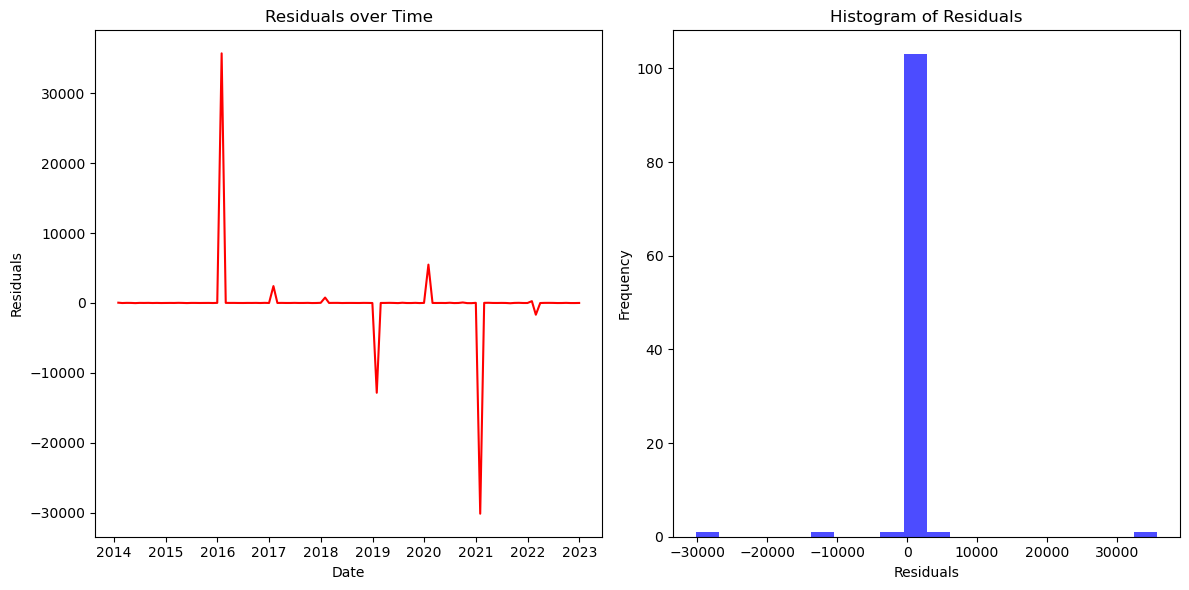

In [6]:

# Extracting residuals
residuals = pd.DataFrame(best_model.resid)

# Plotting residuals
plt.figure(figsize=(12, 6))

# Residuals vs time to check for any patterns
plt.subplot(1, 2, 1)
plt.plot(residuals, color='red')
plt.title('Residuals over Time')
plt.xlabel('Date')
plt.ylabel('Residuals')

# Histogram to check the distribution of residuals
plt.subplot(1, 2, 2)
plt.hist(residuals, bins=20, color='blue', alpha=0.7)
plt.title('Histogram of Residuals')
plt.xlabel('Residuals')
plt.ylabel('Frequency')

plt.tight_layout()
plt.show()

